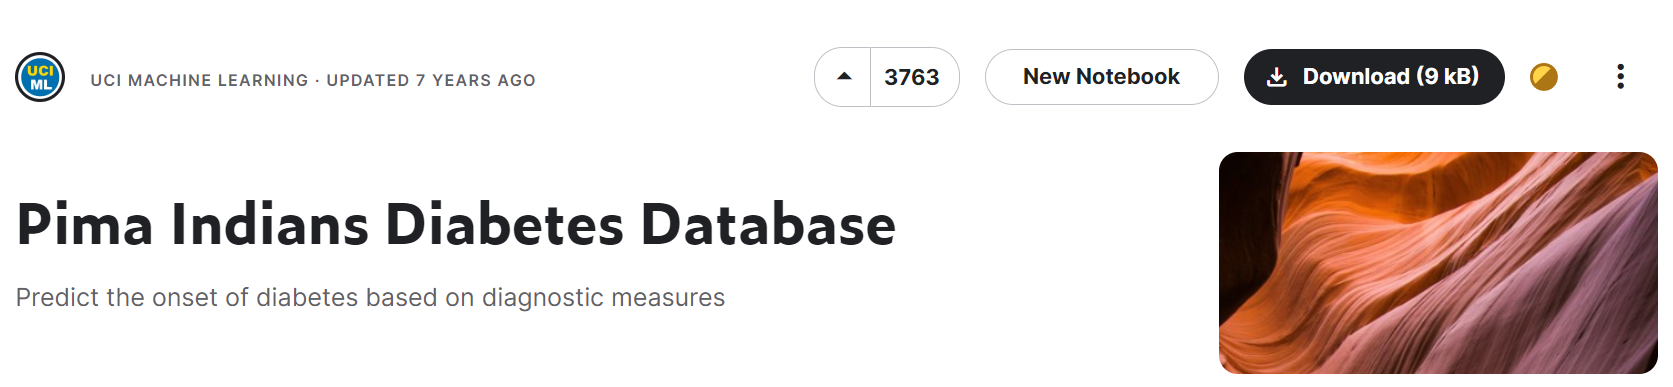
* ref : https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database?resource=download

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------ 훈련데이터
from sklearn.datasets import load_iris
# --------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
# -------------------------------------------------------------------------- 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
# -------------------------------------------------------------------------- 인코딩
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# -------------------------------------------------------------------------- 모델
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# -------------------------------------------------------------------------- 평가
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score 
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
# -------------------------------------------------------------------------- 교차검증
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
# --------------------------------------------------------------------------

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

#-------------------- 차트 관련 속성 (차트크기 ) -----------
# plt.rcParams['figure.figsize'] = (4, 2)
# plt.rcParams['font.size'] = 7

# Data Load
* df.info()
* df.shape
* df.head()

In [3]:
df = pd.read_csv("./diabetes.csv")
# df.columns = ['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin','bmi', 'diabet', 'age', 'outcome']
df.columns = df.columns.str.lower()
df.rename(columns={"diabetespedigreefunction":"diabet"}, inplace=True)
print(df.shape)
df.info()

(768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   pregnancies    768 non-null    int64  
 1   glucose        768 non-null    int64  
 2   bloodpressure  768 non-null    int64  
 3   skinthickness  768 non-null    int64  
 4   insulin        768 non-null    int64  
 5   bmi            768 non-null    float64
 6   diabet         768 non-null    float64
 7   age            768 non-null    int64  
 8   outcome        768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


# 공통함수

In [4]:
def my_score(df) : 
    y = df['outcome']
    X = df.drop('outcome', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
    model = DecisionTreeClassifier(random_state=111, min_samples_split=2)
    model.fit(X_train, y_train)
    pred = model.predict( X_test)  
    proba = model.predict_proba( X_test) 

    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall    = recall_score(y_test, pred)
    f1        = f1_score(y_test, pred)
    roc = roc_auc_score(y_test, proba[:, 1])
    
    print(f"accuracy:{accuracy:.4f} precision:{precision:.4f}  recall:{recall:.4f}   f1:{f1:.4f}  roc:{roc:.4f}")
    print( confusion_matrix(y_test, pred) )

## 우선 점수부터 보자

In [5]:
my_score(df) 

accuracy:0.6623 precision:0.5179  recall:0.5370   f1:0.5273  roc:0.6335
[[73 27]
 [25 29]]


# EDA

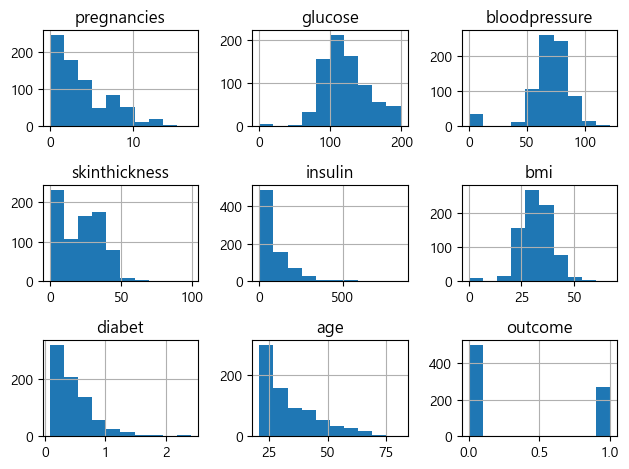

In [6]:
# plt.figure(figsize=(12,4))
df.hist()
plt.tight_layout()
plt.show()

## target 분포도

In [7]:
df['outcome'].value_counts()

0    500
1    268
Name: outcome, dtype: int64

## 결측체크

In [8]:
df.isna().sum()

pregnancies      0
glucose          0
bloodpressure    0
skinthickness    0
insulin          0
bmi              0
diabet           0
age              0
outcome          0
dtype: int64

In [9]:
df.isna().sum() [df.isna().sum() >0]

Series([], dtype: int64)

## 유니크 값 체크

In [10]:
print(df.shape)
for col in df.columns:
    print(f"{col}\t\t {df[col].nunique()}\t {df[col].unique()[:10]}") 

(768, 9)
pregnancies		 17	 [ 6  1  8  0  5  3 10  2  4  7]
glucose		 136	 [148  85 183  89 137 116  78 115 197 125]
bloodpressure		 47	 [72 66 64 40 74 50  0 70 96 92]
skinthickness		 51	 [35 29  0 23 32 45 19 47 38 30]
insulin		 186	 [  0  94 168  88 543 846 175 230  83  96]
bmi		 248	 [33.6 26.6 23.3 28.1 43.1 25.6 31.  35.3 30.5  0. ]
diabet		 517	 [0.627 0.351 0.672 0.167 2.288 0.201 0.248 0.134 0.158 0.232]
age		 52	 [50 31 32 21 33 30 26 29 53 54]
outcome		 2	 [1 0]


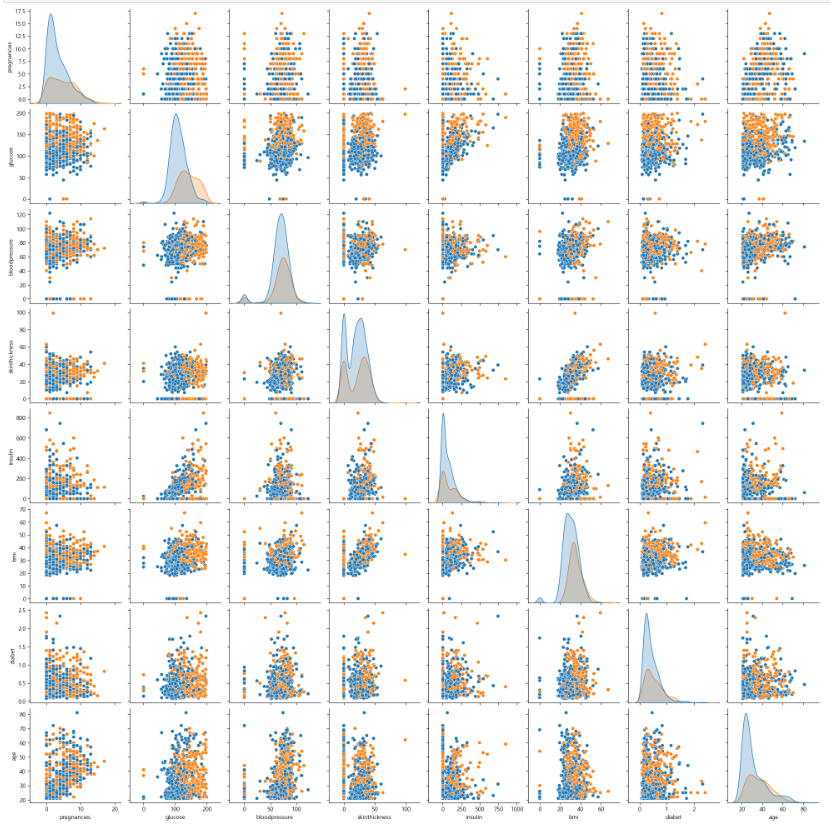

## 0값 데이터 찾기

In [11]:
for col in df.columns:
    cnt = df[df[col]==0][col].count()
    print(f"{col} \t {cnt}")

pregnancies 	 111
glucose 	 5
bloodpressure 	 35
skinthickness 	 227
insulin 	 374
bmi 	 11
diabet 	 0
age 	 0
outcome 	 500


In [12]:
glu_idx = df[df['glucose']==0].index
df[df['glucose']==0]

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabet,age,outcome
75,1,0,48,20,0,24.7,0.140,22,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1


In [13]:
zero_cols = [ 'glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi' ]
df[zero_cols] = df[zero_cols].replace(  0, np.nan )
print(df.isna().sum())

pregnancies        0
glucose            5
bloodpressure     35
skinthickness    227
insulin          374
bmi               11
diabet             0
age                0
outcome            0
dtype: int64


In [14]:
df.groupby('outcome')['glucose'].mean()

outcome
0    110.643863
1    142.319549
Name: glucose, dtype: float64

In [15]:
for col in zero_cols:
    df[col].fillna(  df.groupby('outcome')[col].transform('mean'), inplace=True  )

In [16]:
df.loc[glu_idx]

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabet,age,outcome
75,1,110.643863,48.0,20.0,130.287879,24.7,0.140,22,0
182,1,110.643863,74.0,20.0,23.000000,27.7,0.299,21,0
342,1,110.643863,68.0,35.0,130.287879,32.0,0.389,22,0
349,5,142.319549,80.0,32.0,206.846154,41.0,0.346,37,1
502,6,142.319549,68.0,41.0,206.846154,39.0,0.727,41,1


# 2차 점수보기

In [17]:
my_score(df) 

accuracy:0.8052 precision:0.7143  recall:0.7407   f1:0.7273  roc:0.7904
[[84 16]
 [14 40]]


## 당뇨 vs. 정상 수치

<pre>
glucose        :  공복 후 측정한 혈당이 126 mg/dL 이상                       : 126	
bloodpressure  : 고혈압은 수축기 혈압이 140mmHg 이상,확장기 혈압이 90mmHg 이상 : 90
skinthickness  : 12.72 ± 7.39                                              : 20
insulin	       :  2.6~24.9(uU/mL)   2시간 후 22~79(uU/mL)                   : 25 ~
bmi		       :  25kg/m² 이상부터 비만                                     : 30
diabet	       : 유전력의크기???
age            : 고령 산모(35세 이상)
pregnancies    : 다태 임신                                                  : 4~5
</pre>

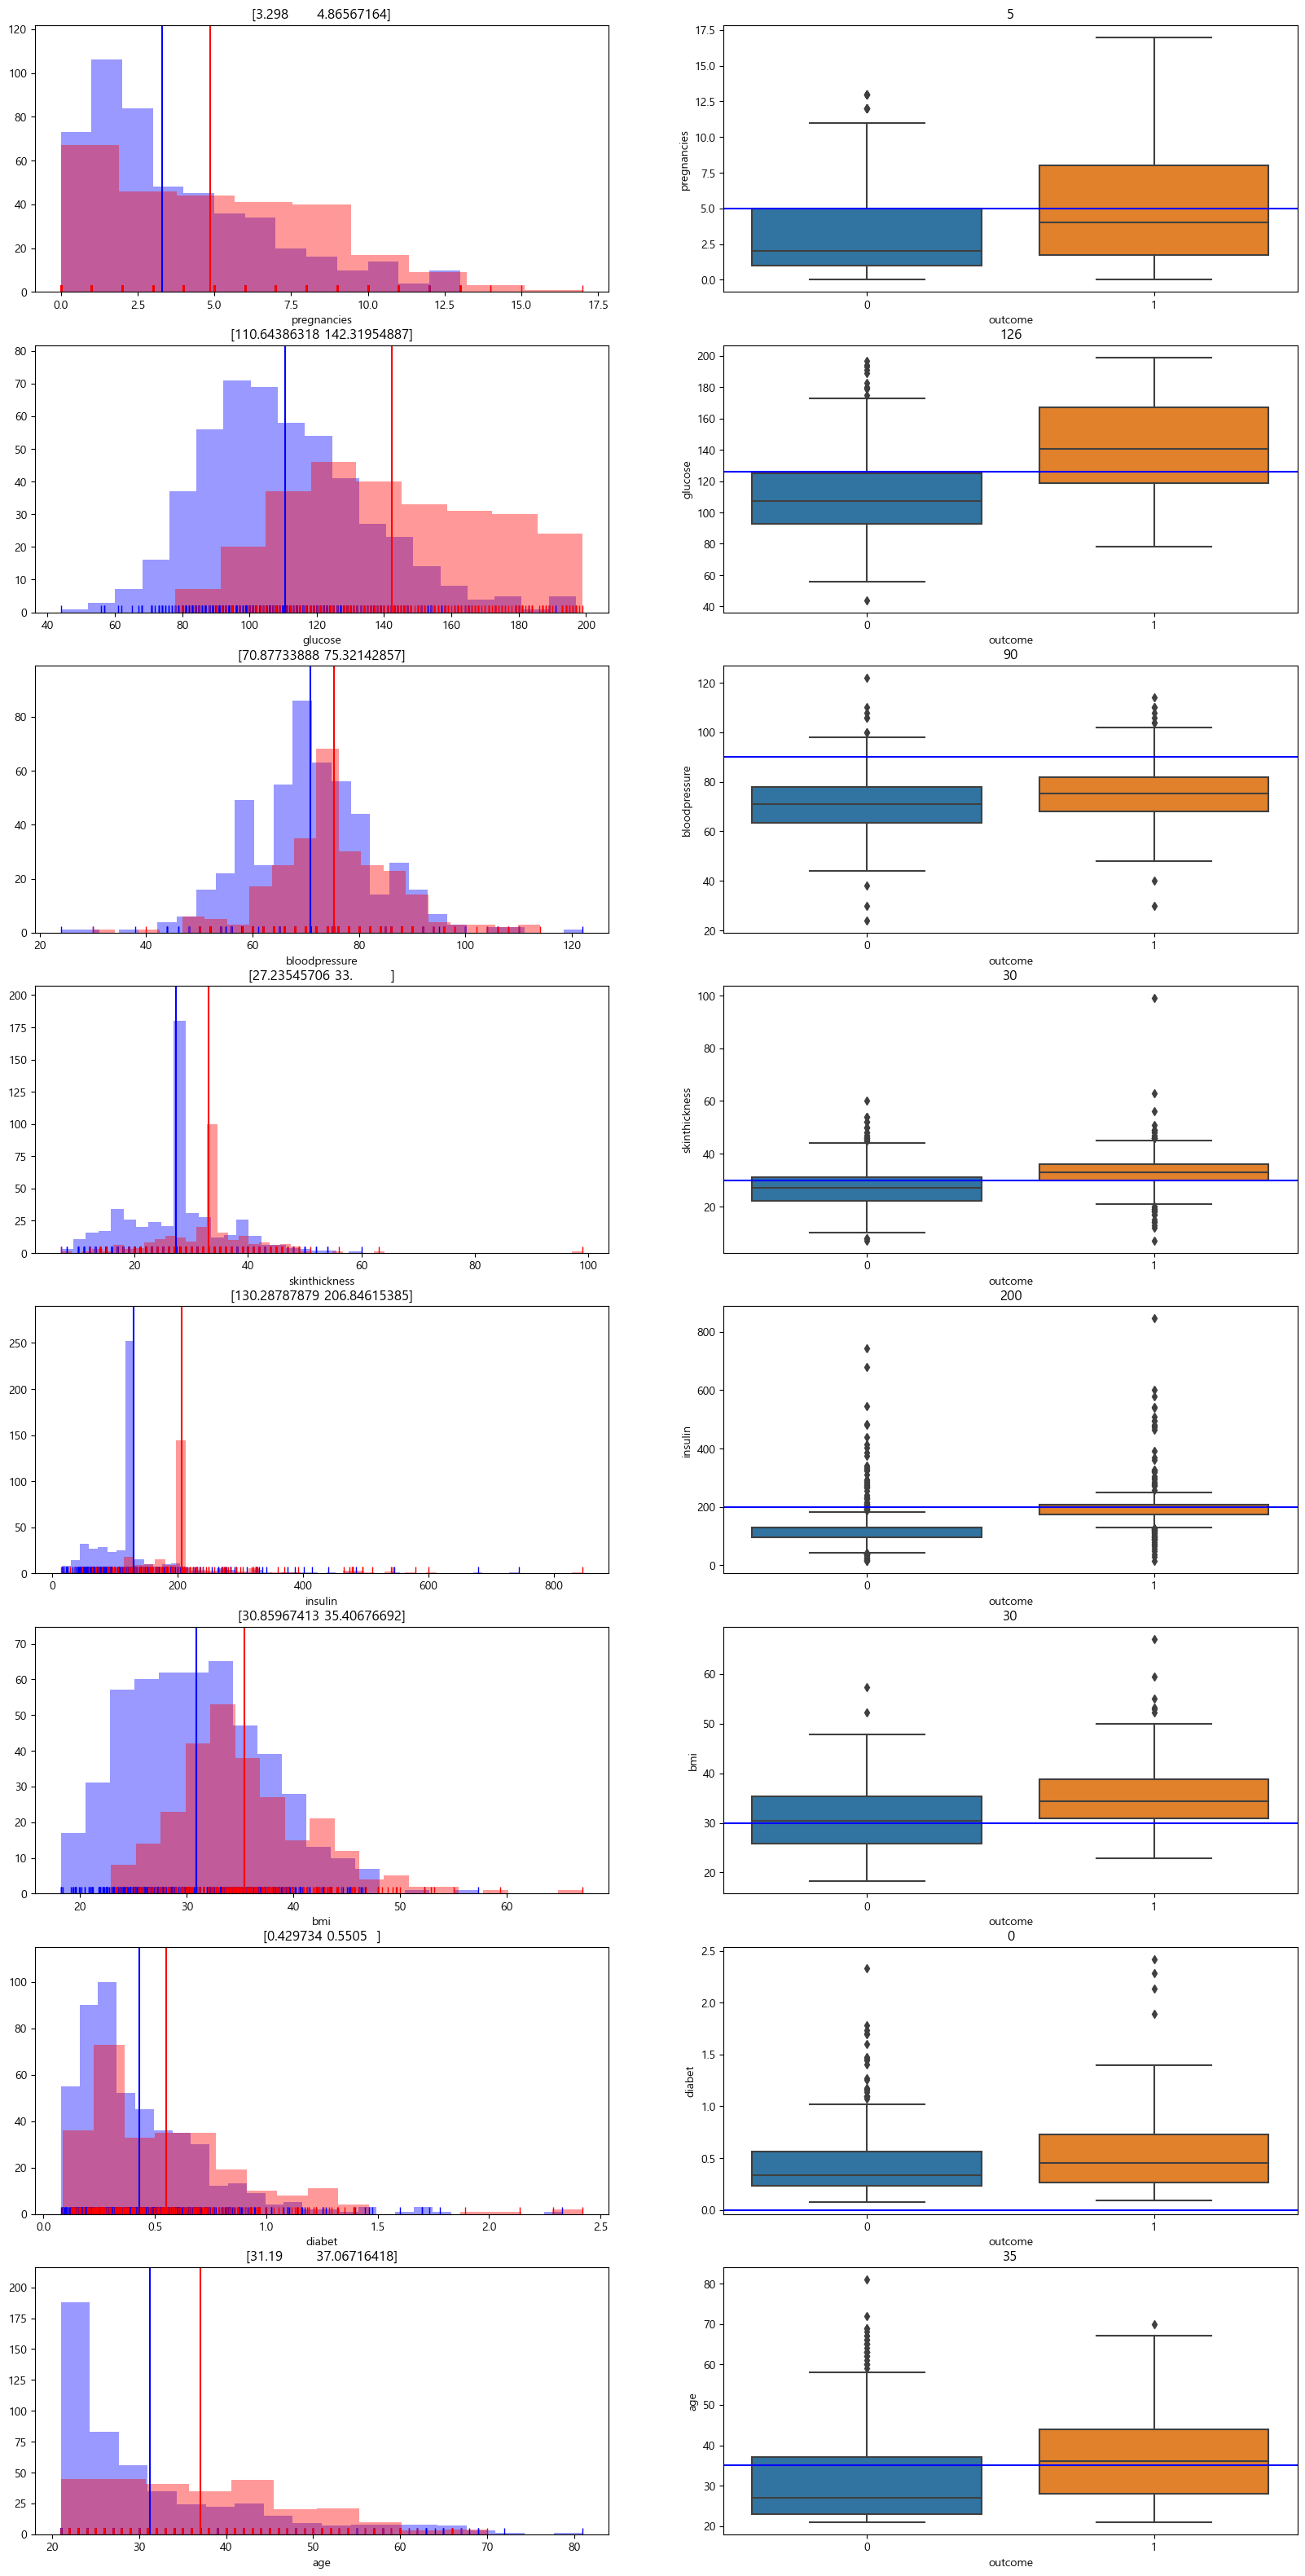

In [18]:
cols = ['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi', 'diabet', 'age']
fig, axes = plt.subplots(nrows=len(cols), ncols=2, figsize=(20, 40))
nomal_val = [5, 126, 90,30, 200, 30, 0, 35]

for i in range(len(cols)):
    col = cols[i]
    sns.distplot(df[df['outcome']==0][col]   , kde=False, rug=True, color="blue", fit_kws={"color":"#E48E58"},label="정상"  ,ax=axes[i][0])
    sns.distplot(df[df['outcome']==1][col]   , kde=False, rug=True, color="red", fit_kws={"color":"#3333FF"},label="당뇨"  ,ax=axes[i][0])
    axes[i][0].axvline(df.groupby('outcome')[col].mean().values[0], color='b')
    axes[i][0].axvline(df.groupby('outcome')[col].mean().values[1], color='r')
    axes[i][0].set_title(f"{df.groupby('outcome')[col].mean().values}")
    
    sns.boxplot(x="outcome",     y=col, data=df,  ax=axes[i][1])
    axes[i][1].axhline(nomal_val[i], color='b')
    axes[i][1].set_title(f"{nomal_val[i]}")
plt.show()
plt.close()

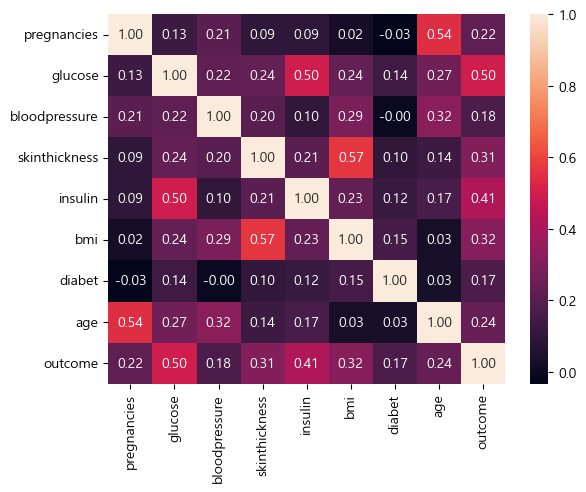

In [19]:
sns.heatmap(df.corr(), fmt='.2f', annot=True)
plt.show()

<pre>
glucose (0.47) - insulin(0.33) bmi(0.22)   age(0.26)
insuline()
bmi  (0.29)    - blood(0.28)    skin(0.39)
age  (0.24)    - preg(0.54)     blood(0.24)
preg (0.22)

## glucose

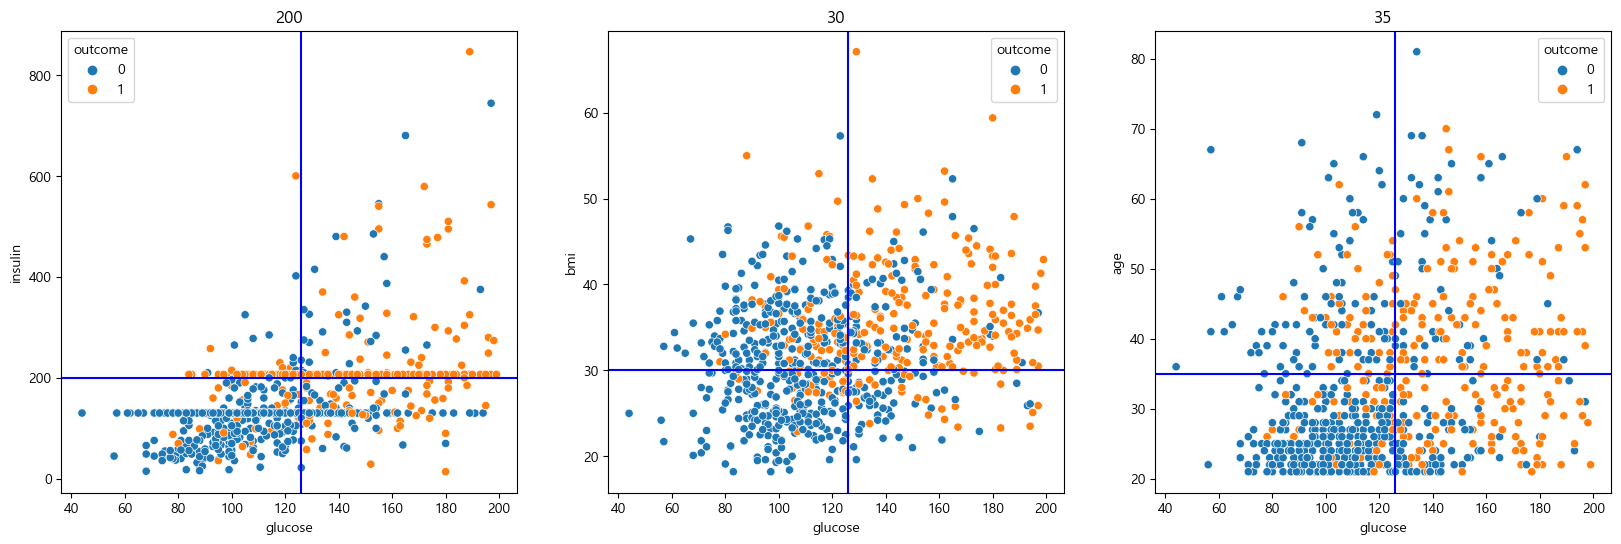

In [20]:

# cols      = ['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi', 'diabet', 'age']
# nomal_val = [5, 126, 90,20, 80, 30, 0, 35]

sub_cols = ["insulin", "bmi", "age"]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
sns.scatterplot(x="glucose", y=sub_cols[0], data=df, hue="outcome",ax=axes[0])
axes[0].axvline(nomal_val[1], color='b')
axes[0].axhline(nomal_val[4], color='b')
axes[0].set_title(f"{nomal_val[4]}")

sns.scatterplot(x="glucose", y=sub_cols[1], data=df, hue="outcome",ax=axes[1])
axes[1].axvline(nomal_val[1], color='b')
axes[1].axhline(nomal_val[5], color='b')
axes[1].set_title(f"{nomal_val[5]}")

sns.scatterplot(x="glucose", y=sub_cols[2], data=df, hue="outcome",ax=axes[2])
axes[2].axvline(nomal_val[1], color='b')
axes[2].axhline(nomal_val[7], color='b')
axes[2].set_title(f"{nomal_val[7]}")

plt.show()


## bmi

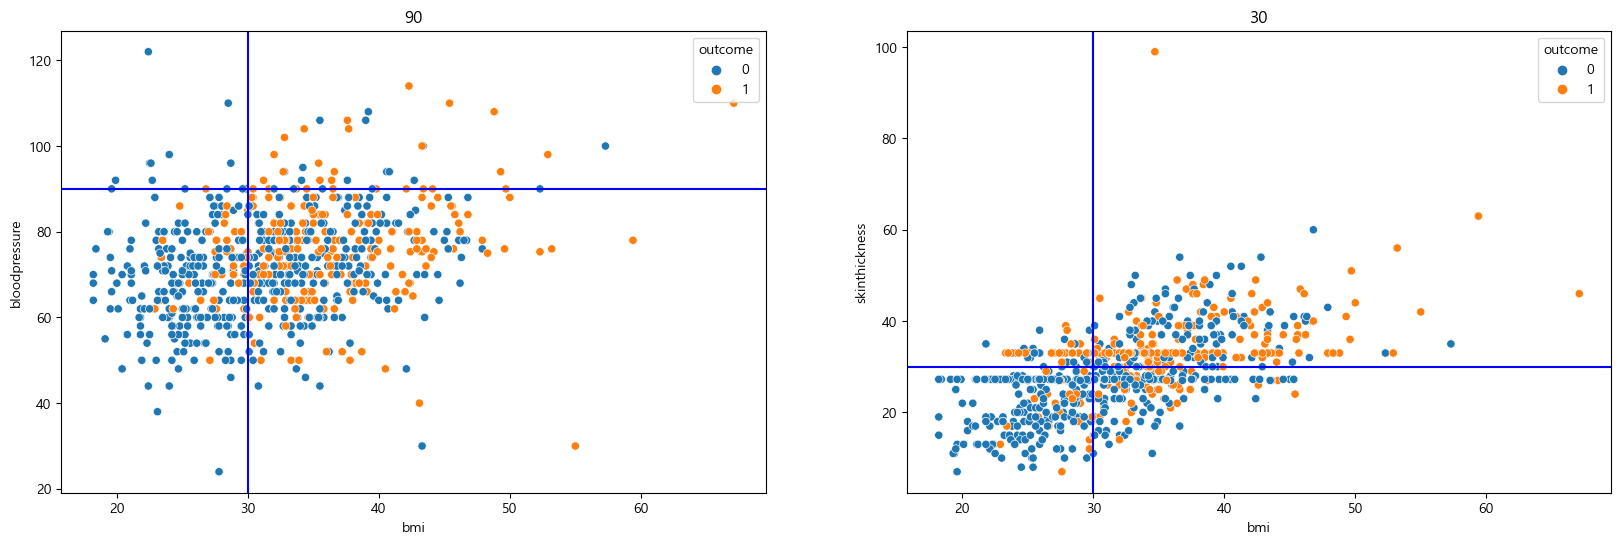

In [21]:

# cols      = ['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi', 'diabet', 'age']
# nomal_val = [5, 126, 90,20, 80, 30, 0, 35]

sub_cols = ["bloodpressure","skinthickness"]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
sns.scatterplot(x="bmi", y=sub_cols[0], data=df, hue="outcome",ax=axes[0])
axes[0].axvline(nomal_val[5], color='b')
axes[0].axhline(nomal_val[2], color='b')
axes[0].set_title(f"{nomal_val[2]}")

sns.scatterplot(x="bmi", y=sub_cols[1], data=df, hue="outcome",ax=axes[1])
axes[1].axvline(nomal_val[5], color='b')
axes[1].axhline(nomal_val[3], color='b')
axes[1].set_title(f"{nomal_val[3]}")

plt.show()

## age

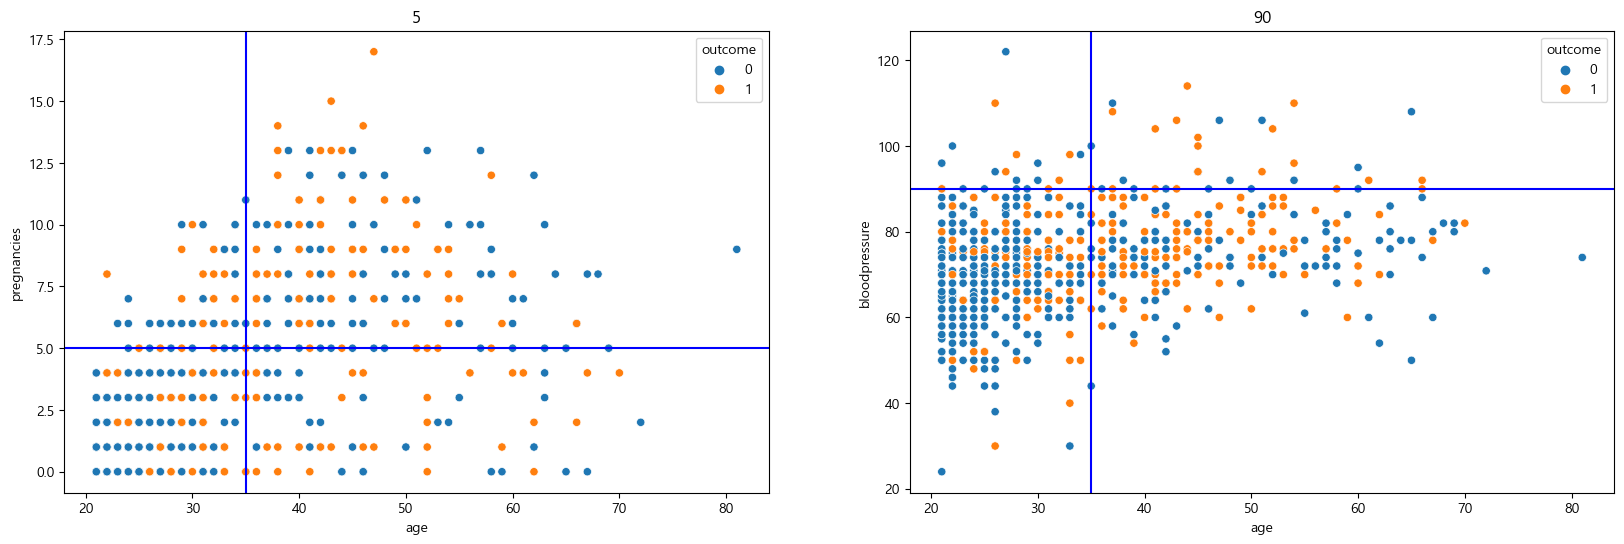

In [22]:

# cols      = ['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi', 'diabet', 'age']
# nomal_val = [5, 126, 90,20, 80, 30, 0, 35]

sub_cols = ["pregnancies","bloodpressure"]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
sns.scatterplot(x="age", y=sub_cols[0], data=df, hue="outcome",ax=axes[0])
axes[0].axvline(nomal_val[7], color='b')
axes[0].axhline(nomal_val[0], color='b')
axes[0].set_title(f"{nomal_val[0]}")

sns.scatterplot(x="age", y=sub_cols[1], data=df, hue="outcome",ax=axes[1])
axes[1].axvline(nomal_val[7], color='b')
axes[1].axhline(nomal_val[2], color='b')
axes[1].set_title(f"{nomal_val[2]}")

plt.show()

# 피쳐 전처리 & 가공
* 결측처리
* 인코딩<br><br>

* 아웃라이어 처리
* 스케일링(연속형) - 정규분포화(왜도, 첨도)
* 더미화(이산형) - one-hot
* 바이닝(수치형) - 구간화
* 파생피쳐<br><br>

* 다중공선 - 피쳐삭제, 차원축소, 컬럼합치기

## 아웃라이어 

* 연습용

In [23]:
tmp = []
a = [1,2]
b = [3,4]
tmp.append(a)
tmp.append(b)
tmp

[[1, 2], [3, 4]]

In [24]:
tmp = []
a = [1,2]
b = [3,4]
tmp.extend(a)
tmp.extend(b)
tmp

[1, 2, 3, 4]

In [25]:
tmp = []
a = [1,2]
b = [3,4]
tmp.append(a)
tmp.extend(b)
tmp

[[1, 2], 3, 4]

### IQR로 처리

In [26]:
df['insulin'].quantile(0.25)

121.5

In [27]:
df['insulin'].quantile([0.25, .75]).values[0]

121.5

In [28]:
np.percentile(df['insulin'].values, 25)

121.5

In [29]:
np.percentile(df['insulin'].values, [25, 75])[0]

121.5

In [30]:
q1 = df['insulin'].quantile(0.25)
q3 = df['insulin'].quantile(0.75)
iqr = q3 - q1
lower = q1 - (1.5*iqr)
upper = q3 + (1.5*iqr)
lower, upper

(-6.519230769230774, 334.86538461538464)

In [31]:
print(  df[ (df['insulin']<lower) | (df['insulin']>upper) ].shape )
df[ (df['insulin']<lower) | (df['insulin']>upper)].head()

(27, 9)


,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabet,age,outcome
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
13,1,189.0,60.0,23.0,846.0,30.1,0.398,59,1
54,7,150.0,66.0,42.0,342.0,34.7,0.718,42,0
111,8,155.0,62.0,26.0,495.0,34.0,0.543,46,1
153,1,153.0,82.0,42.0,485.0,40.6,0.687,23,0


In [32]:
iqr_del_cols = ['pregnancies' , 'skinthickness' , 'insulin' , 'bmi']
iqr_del_idx = []
for col in iqr_del_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - (1.5*iqr)
    upper = q3 + (1.5*iqr)
    # print(col, lower, upper)
    idx = df[ (df[col]<lower) | (df[col]>upper)].index
    iqr_del_idx.extend(  idx  )
    #print( idx )
iqr_del_idx[:5]   

[88, 159, 298, 455, 16]

In [33]:
dfcp = df.copy()
dfcp.drop(iqr_del_idx, axis=0, inplace=True)
my_score(dfcp)

accuracy:0.8540 precision:0.7442  recall:0.7805   f1:0.7619  roc:0.8330
[[85 11]
 [ 9 32]]


<pre>원본: accuracy:0.8052 precision:0.7143  recall:0.7407   f1:0.7273  roc:0.7904
[[84 16]
 [14 40]]

 개별: accuracy:0.8675 precision:0.8103  recall:0.8393   f1:0.8246  roc:0.8617
[[84 11]
 [ 9 47]]

### 개별 피쳐에서 처리

In [34]:
df.columns

Index(['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin',
       'bmi', 'diabet', 'age', 'outcome'],
      dtype='object')

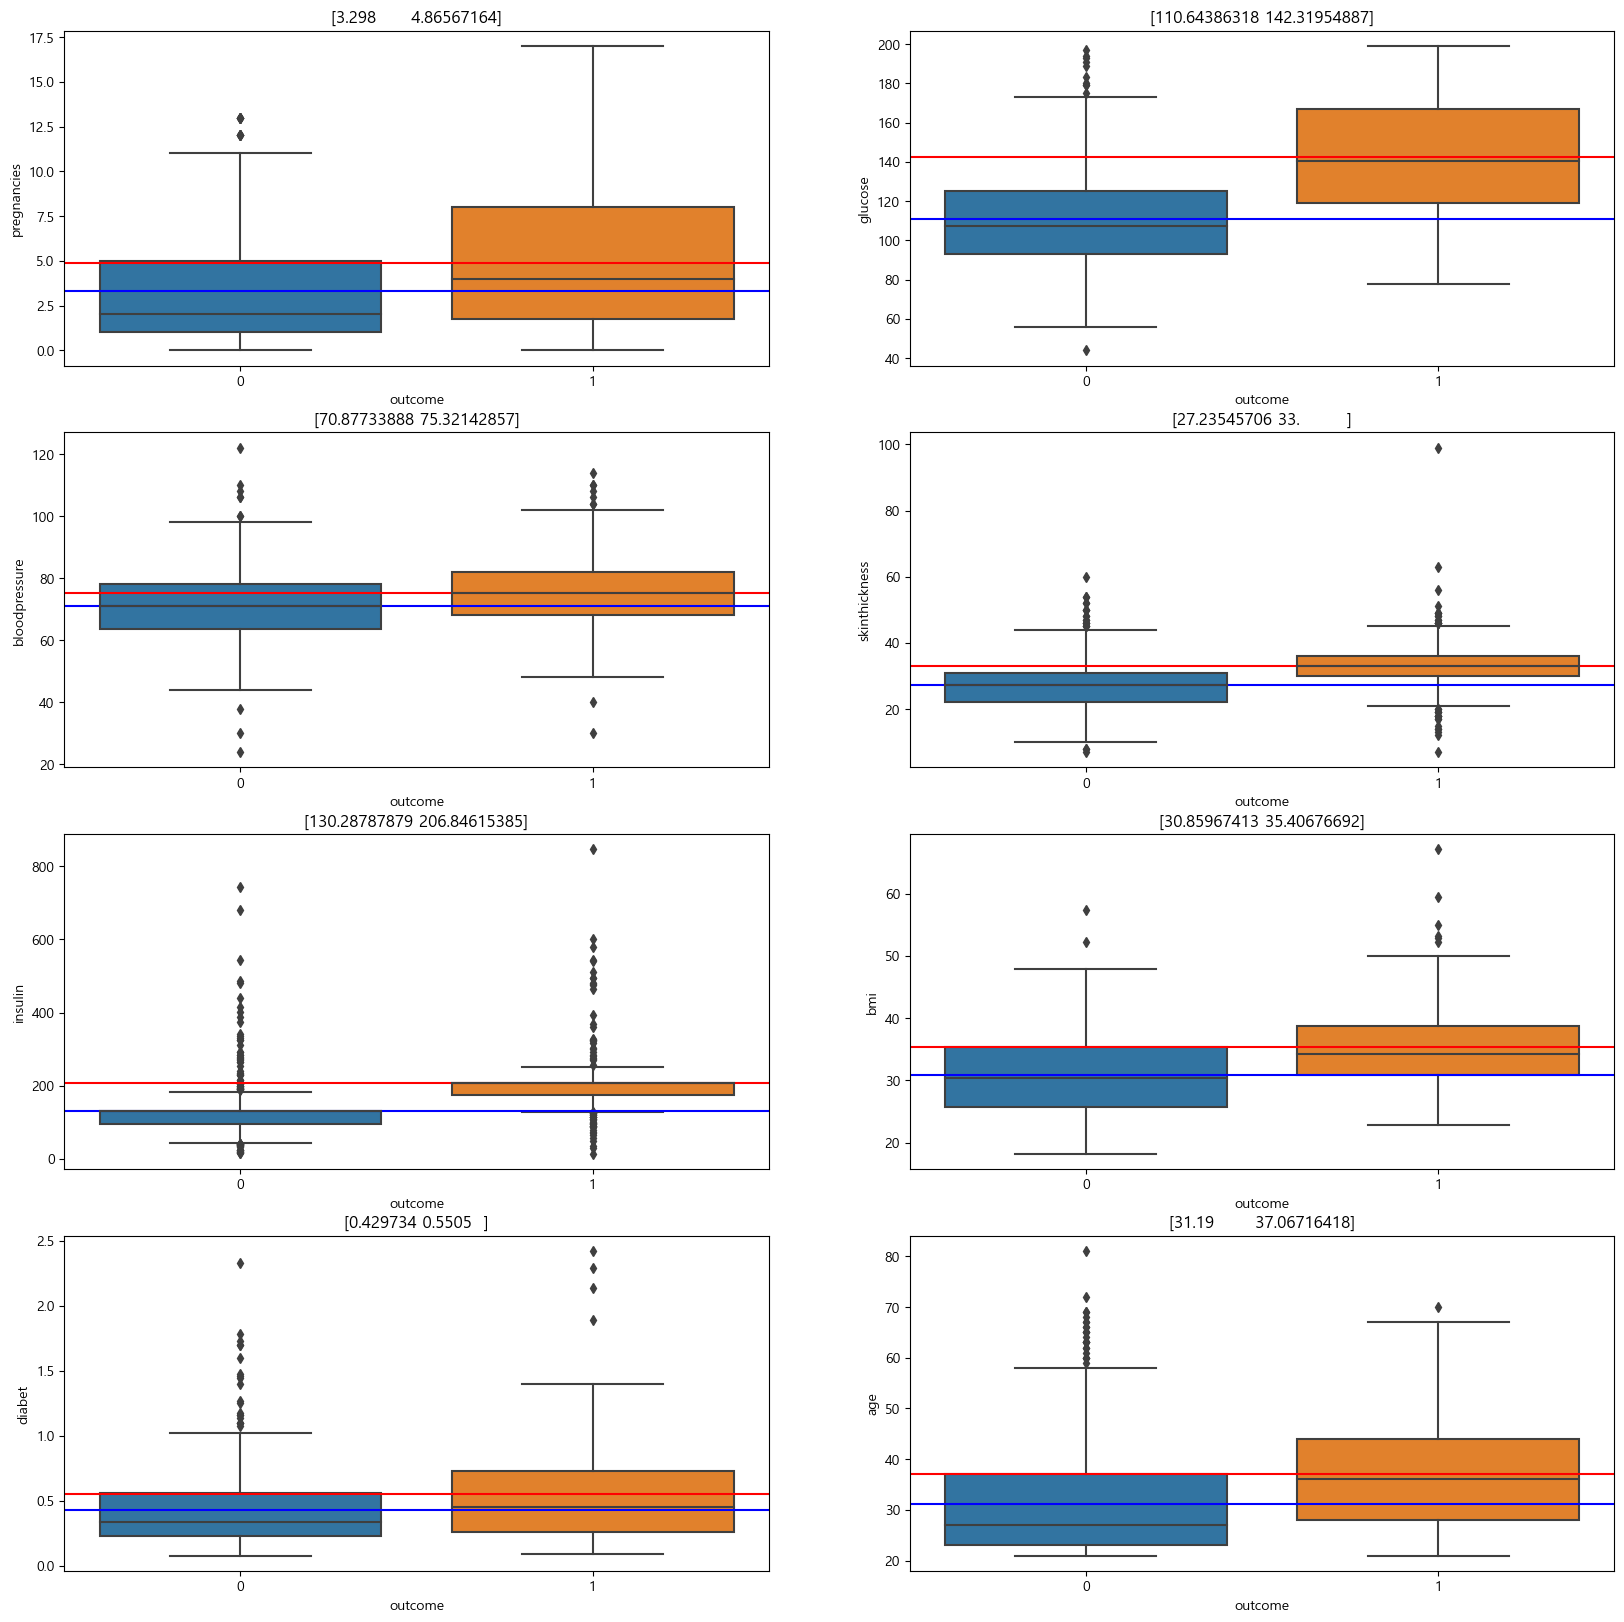

In [35]:
cols = ['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin','bmi', 'diabet', 'age']
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))
nomal_val = [5, 126, 90,30, 200, 30, 0, 35]

for i in range(len(cols)):
    col = cols[i]
    r = i//2
    c = i%2
    sns.boxplot(x="outcome",   y=col, data=df  ,ax=axes[r][c])
    axes[r][c].axhline(df.groupby('outcome')[col].mean().values[0], color='b')
    axes[r][c].axhline(df.groupby('outcome')[col].mean().values[1], color='r')
    axes[r][c].set_title(f"{df.groupby('outcome')[col].mean().values}")
plt.show()
plt.close()

* 정상인 임신횟수 12회 이상

In [36]:
del_outlier_idx = []

In [37]:
del_outlier_idx.extend(df[(df['outcome']==0) & (df['pregnancies'] >=12)].index)
print(del_outlier_idx)
df[(df['outcome']==0) & (df['pregnancies'] >=12)].head()

[28, 86, 274, 333, 358, 436, 518, 582, 744, 745]


,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabet,age,outcome
28,13,145.0,82.0,19.000000,110.000000,22.2,0.245,57,0
86,13,106.0,72.0,54.000000,130.287879,36.6,0.178,45,0
274,13,106.0,70.0,27.235457,130.287879,34.2,0.251,52,0
333,12,106.0,80.0,27.235457,130.287879,23.6,0.137,44,0
358,12,88.0,74.0,40.000000,54.000000,35.3,0.378,48,0


In [38]:
dfcp = df.copy()
dfcp.drop(del_outlier_idx, axis=0, inplace=True)
my_score(dfcp) 

accuracy:0.8158 precision:0.7917  recall:0.6786   f1:0.7308  roc:0.7872
[[86 10]
 [18 38]]


<pre>accuracy:0.8052 precision:0.7143  recall:0.7407   f1:0.7273  roc:0.7904
[[84 16]
 [14 40]]

* skinthicknes >= 90

In [39]:
del_outlier_idx.extend(df[df['skinthickness'] >=90].index)
print(del_outlier_idx)
df[df['skinthickness'] >=90].head()

[28, 86, 274, 333, 358, 436, 518, 582, 744, 745, 579]


,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabet,age,outcome
579,2,197.0,70.0,99.0,206.846154,34.7,0.575,62,1


In [40]:
dfcp = df.copy()
dfcp.drop(del_outlier_idx, axis=0, inplace=True)
my_score(dfcp) 

accuracy:0.8684 precision:0.8302  recall:0.8000   f1:0.8148  roc:0.8536
[[88  9]
 [11 44]]


<pre>accuracy:0.8052 precision:0.7143  recall:0.7407   f1:0.7273  roc:0.7904
[[84 16]
 [14 40]]e>

* insulin > 800

In [41]:
del_outlier_idx.extend(df[df['insulin'] >=800].index)
print(del_outlier_idx)
df[df['insulin'] >=800].head()

[28, 86, 274, 333, 358, 436, 518, 582, 744, 745, 579, 13]


,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabet,age,outcome
13,1,189.0,60.0,23.0,846.0,30.1,0.398,59,1


In [42]:
dfcp = df.copy()
dfcp.drop(del_outlier_idx, axis=0, inplace=True)
my_score(dfcp) 

accuracy:0.8618 precision:0.7955  recall:0.7447   f1:0.7692  roc:0.8295
[[96  9]
 [12 35]]


<pre>accuracy:0.8052 precision:0.7143  recall:0.7407   f1:0.7273  roc:0.7904
[[84 16]
 [14 40]]

* bmi > 60

In [43]:
del_outlier_idx.extend(df[df['bmi'] >=60].index)
print(del_outlier_idx)
df[df['bmi'] >=60].head()

[28, 86, 274, 333, 358, 436, 518, 582, 744, 745, 579, 13, 177]


,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabet,age,outcome
177,0,129.0,110.0,46.0,130.0,67.1,0.319,26,1


In [44]:
dfcp = df.copy()
dfcp.drop(del_outlier_idx, axis=0, inplace=True)
my_score(dfcp) 

accuracy:0.8675 precision:0.8103  recall:0.8393   f1:0.8246  roc:0.8617
[[84 11]
 [ 9 47]]


<pre>accuracy:0.8052 precision:0.7143  recall:0.7407   f1:0.7273  roc:0.7904
[[84 16]
 [14 40]]

### 3차 점수보기
* 모든 아웃라이어 제거 후 

In [45]:
df.drop(del_outlier_idx, axis=0, inplace=True)
my_score(df) 

accuracy:0.8675 precision:0.8103  recall:0.8393   f1:0.8246  roc:0.8617
[[84 11]
 [ 9 47]]


<pre>원본 : accuracy:0.8052 precision:0.7143  recall:0.7407   f1:0.7273  roc:0.7904
[[84 16]
 [14 40]]

 개별 아웃라이어 삭제 : accuracy:0.8675 precision:0.8103  recall:0.8393   f1:0.8246  roc:0.8617
[[84 11]
 [ 9 47]]]]

## 정규화
* 스케일링
* 왜도(skew), 첨도(kurtosis)
* https://rfriend.tistory.com/123

## 왜도(skew)
* 좌우 대칭 정도
* 음수(-) :  오른쪽치우침
* 양수(+) :  왼쪽치우침

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F222B9D4B561B05A420">

## 첨도(kurtosis)
* 뾰족한 정도
* 음수(-) : 바닥쪽으로 덜 뾰족함(납작)* 
양수(+) :위쪽으로 뾰족함침

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F2131054A561B0CE743">

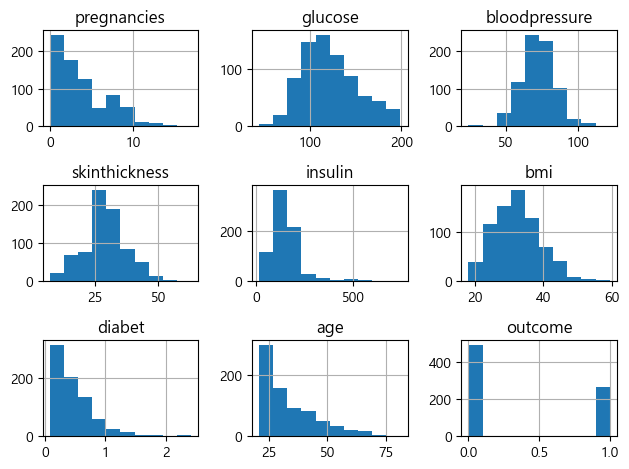

In [46]:
df.hist()
plt.tight_layout()
plt.show()

In [47]:
from scipy.stats import kurtosis, skew

In [48]:
# skew(df['age'])
# df['age'].skew()

In [49]:
sk = pd.DataFrame(columns=["col","skew","kur"]) 
sk['col'] = df.columns
sk['skew'] = skew(df)
sk['kur'] = kurtosis(df)
sk

,col,skew,kur
0,pregnancies,0.872210,0.155151
1,glucose,0.524263,-0.278952
2,bloodpressure,0.114359,1.049315
3,skinthickness,0.168378,0.524895
4,insulin,2.284387,9.043451
5,bmi,0.482136,0.280048
6,diabet,1.911803,5.543764
7,age,1.172227,0.790862
8,outcome,0.624398,-1.610127


* Kline(2005)은 왜도의 기준을 절대값 3을 초과하지 않고, 첨도는 절대값 8또는 10을 초과하지 않으면 정규분포로 볼 수 있다고 제시하였습니다.

In [50]:
sk.sort_values(by="skew", ascending=False)

,col,skew,kur
4,insulin,2.284387,9.043451
6,diabet,1.911803,5.543764
7,age,1.172227,0.790862
0,pregnancies,0.872210,0.155151
8,outcome,0.624398,-1.610127
1,glucose,0.524263,-0.278952
5,bmi,0.482136,0.280048
3,skinthickness,0.168378,0.524895
2,bloodpressure,0.114359,1.049315


In [51]:
sk.sort_values(by="kur", ascending=False)

,col,skew,kur
4,insulin,2.284387,9.043451
6,diabet,1.911803,5.543764
2,bloodpressure,0.114359,1.049315
7,age,1.172227,0.790862
3,skinthickness,0.168378,0.524895
5,bmi,0.482136,0.280048
0,pregnancies,0.872210,0.155151
1,glucose,0.524263,-0.278952
8,outcome,0.624398,-1.610127


## 로그스케일링
* np.log1p()

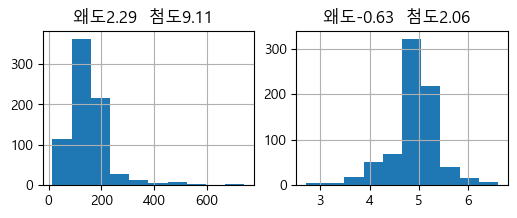

In [52]:
plt.figure(figsize=(6,2))
plt.subplot(1,2,1)
df['insulin'].hist()
plt.title(f"왜도{df['insulin'].skew():.2f}  첨도{df['insulin'].kurtosis():.2f}  ")

plt.subplot(1,2,2)
np.log1p(df['insulin']).hist()
plt.title(f"왜도{np.log1p(df['insulin']).skew():.2f}  첨도{np.log1p(df['insulin']).kurtosis():.2f}  ")

plt.show()

In [53]:
df['insulin'].head(5)

0    206.846154
1    130.287879
2    206.846154
3     94.000000
4    168.000000
Name: insulin, dtype: float64

In [54]:
dfcp = df.copy()
dfcp['insulin'] = np.log1p(dfcp['insulin'])
dfcp['insulin'].head(5)        

0    5.336798
1    4.877392
2    5.336798
3    4.553877
4    5.129899
Name: insulin, dtype: float64

In [55]:
my_score(dfcp)

accuracy:0.8675 precision:0.8103  recall:0.8393   f1:0.8246  roc:0.8617
[[84 11]
 [ 9 47]]


<pre>원본 : accuracy:0.8052 precision:0.7143  recall:0.7407   f1:0.7273  roc:0.7904
[[84 16]
 [14 40]]

 개별 아웃라이어 삭제 : accuracy:0.8675 precision:0.8103  recall:0.8393   f1:0.8246  roc:0.8617
[[84 11]
 [ 9 47]]]]

In [56]:
dfcp = df.copy()
dfcp[['glucose', 'bloodpressure', 'skinthickness', 'insulin','bmi', 'diabet']] = np.log1p(dfcp[['glucose', 'bloodpressure', 'skinthickness', 'insulin','bmi', 'diabet']])
dfcp.head(2)        

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabet,age,outcome
0,6,5.003946,4.290459,3.583519,5.336798,3.543854,0.486738,50,1
1,1,4.454347,4.204693,3.401197,4.877392,3.317816,0.300845,31,0


In [57]:
my_score(dfcp)

accuracy:0.8609 precision:0.8070  recall:0.8214   f1:0.8142  roc:0.8528
[[84 11]
 [10 46]]


<pre>원본 : accuracy:0.8052 precision:0.7143  recall:0.7407   f1:0.7273  roc:0.7904
[[84 16]
 [14 40]]

 개별 아웃라이어 삭제 : accuracy:0.8675 precision:0.8103  recall:0.8393   f1:0.8246  roc:0.8617
[[84 11]
 [ 9 47]]]]

## sklearn.__scaler()
* from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [58]:
# len(y), len(X)

scale_cols = ['glucose', 'bloodpressure', 'skinthickness', 'insulin','bmi', 'diabet']
scaler_list = [StandardScaler(), MinMaxScaler(), RobustScaler()]

for scaler in scaler_list:
    y = df['outcome']
    X = df.drop('outcome', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

    print(scaler.__class__.__name__)
    scaler.fit(X_train[scale_cols])
    X_train[scale_cols] =  scaler.transform(X_train[scale_cols])
    X_test[scale_cols]  =  scaler.transform(X_test[scale_cols])

    #-----------------------------------------------------
    # #my_score(df)
    #-----------------------------------------------------
    model = DecisionTreeClassifier(random_state=111, min_samples_split=2)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)  
    proba = model.predict_proba(X_test) 

    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall    = recall_score(y_test, pred)
    f1        = f1_score(y_test, pred)
    roc = roc_auc_score(y_test, proba[:, 1])
    
    print(f"accuracy:{accuracy:.4f} precision:{precision:.4f}  recall:{recall:.4f}   f1:{f1:.4f}  roc:{roc:.4f}")
    print( confusion_matrix(y_test, pred) )

StandardScaler
accuracy:0.8609 precision:0.8070  recall:0.8214   f1:0.8142  roc:0.8528
[[84 11]
 [10 46]]
MinMaxScaler
accuracy:0.8675 precision:0.8103  recall:0.8393   f1:0.8246  roc:0.8617
[[84 11]
 [ 9 47]]
RobustScaler
accuracy:0.8609 precision:0.8070  recall:0.8214   f1:0.8142  roc:0.8528
[[84 11]
 [10 46]]


<pre>원본 : accuracy:0.8052 precision:0.7143  recall:0.7407   f1:0.7273  roc:0.7904
[[84 16]
 [14 40]]

 개별 아웃라이어 삭제 : accuracy:0.8675 precision:0.8103  recall:0.8393   f1:0.8246  roc:0.8617
[[84 11]
 [ 9 47]]

 로그스케일 : accuracy:0.8609 precision:0.8070  recall:0.8214   f1:0.8142  roc:0.8528
[[84 11]
 [10 46
 [10 46]]]]]]

## 더미화(원핫)
* sklearn.prepocessing.OneHotEncoder
* pd.get_dummies()

* concat 연습용

In [59]:
# help(pd.DataFrame)

In [60]:
a = pd.DataFrame([[1,10,100], [2,20,200]], index=["a","b"])
print(a.head())
b = pd.DataFrame([['a','aa'], ['b','bb']], index=["b","c"])
print(b.head())
pd.concat([a,b], axis=1, ignore_index=True)

   0   1    2
a  1  10  100
b  2  20  200
   0   1
b  a  aa
c  b  bb


,0,1,2,3,4
a,1.0,10.0,100.0,NaN,NaN
b,2.0,20.0,200.0,a,aa
c,NaN,NaN,NaN,b,bb


### OneHotEncoder

In [61]:
df['pregnancies'].head(3)

0    6
1    1
2    8
Name: pregnancies, dtype: int64

In [62]:
X_train['pregnancies'].values.reshape(-1,1)[:5]

array([[0],
       [2],
       [1],
       [1],
       [1]], dtype=int64)

In [63]:
y = df['outcome']
X = df.drop('outcome', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

oh = OneHotEncoder(sparse=False, dtype='int')  #---------  sparse=False 속성 주의

oh.fit(X_train['pregnancies'].values.reshape(-1,1))
oh_train = oh.transform(X_train['pregnancies'].values.reshape(-1,1))    
oh_test  = oh.transform(X_test['pregnancies'].values.reshape(-1,1))    
print( oh_train[:3] )
print( oh.categories_ )

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17],
      dtype=int64)]


In [64]:
oh_train_df = pd.DataFrame(oh_train, columns=oh.categories_, index=X_train.index)
oh_test_df  = pd.DataFrame(oh_test , columns=oh.categories_, index=X_test.index)
oh_train_df.columns = ["pregnancies_" + str(col) for col in oh.categories_[0]]
oh_test_df.columns  = ["pregnancies_" + str(col) for col in oh.categories_[0]]
oh_train_df.head(2)

,pregnancies_0,pregnancies_1,pregnancies_2,pregnancies_3,pregnancies_4,pregnancies_5,pregnancies_6,pregnancies_7,pregnancies_8,pregnancies_9,pregnancies_10,pregnancies_11,pregnancies_12,pregnancies_13,pregnancies_14,pregnancies_15,pregnancies_17
608,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
573,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [65]:
X_train.drop('pregnancies', axis=1, inplace=True)
X_test.drop('pregnancies', axis=1, inplace=True)

X_train = pd.concat([X_train, oh_train_df], axis=1)
X_test  = pd.concat([X_test , oh_test_df] , axis=1)
X_train.head(2)

,glucose,bloodpressure,skinthickness,insulin,bmi,diabet,age,pregnancies_0,pregnancies_1,pregnancies_2,...,pregnancies_7,pregnancies_8,pregnancies_9,pregnancies_10,pregnancies_11,pregnancies_12,pregnancies_13,pregnancies_14,pregnancies_15,pregnancies_17
608,152.0,82.0,39.0,272.0,41.5,0.270,27,1,0,0,...,0,0,0,0,0,0,0,0,0,0
573,98.0,60.0,17.0,120.0,34.7,0.198,22,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [66]:
#-----------------------------------------------------
# #my_score(df)
#-----------------------------------------------------
model = DecisionTreeClassifier(random_state=111, min_samples_split=2)
model.fit(X_train, y_train)
pred = model.predict(X_test)  
proba = model.predict_proba(X_test) 

accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall    = recall_score(y_test, pred)
f1        = f1_score(y_test, pred)
roc = roc_auc_score(y_test, proba[:, 1])

print(f"accuracy:{accuracy:.4f} precision:{precision:.4f}  recall:{recall:.4f}   f1:{f1:.4f}  roc:{roc:.4f}")
print( confusion_matrix(y_test, pred) )

accuracy:0.8675 precision:0.8462  recall:0.7857   f1:0.8148  roc:0.8508
[[87  8]
 [12 44]]


<pre>원본 : accuracy:0.8052 precision:0.7143  recall:0.7407   f1:0.7273  roc:0.7904
[[84 16]
 [14 40]]

 개별 아웃라이어 삭제 : accuracy:0.8675 precision:0.8103  recall:0.8393   f1:0.8246  roc:0.8617
[[84 11]
 [ 9 47]]

 로그스케일 : accuracy:0.8609 precision:0.8070  recall:0.8214   f1:0.8142  roc:0.8528
[[84 11]
 [10 46]]]]
    
MinMaxScaler
accuracy:0.8675 precision:0.8103  recall:0.8393   f1:0.8246  roc:0.8617
[[84 11]
 [ 9 47]]

### pd.get_dummies()

In [67]:
pd.get_dummies(df['pregnancies'],  dtype='int')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
764,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
765,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
766,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [68]:
dfcp = pd.get_dummies(df,  dtype='int', columns=["pregnancies"])
dfcp.head(3)

,glucose,bloodpressure,skinthickness,insulin,bmi,diabet,age,outcome,pregnancies_0,pregnancies_1,...,pregnancies_7,pregnancies_8,pregnancies_9,pregnancies_10,pregnancies_11,pregnancies_12,pregnancies_13,pregnancies_14,pregnancies_15,pregnancies_17
0,148.0,72.0,35.0,206.846154,33.6,0.627,50,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,85.0,66.0,29.0,130.287879,26.6,0.351,31,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,183.0,64.0,33.0,206.846154,23.3,0.672,32,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [69]:
my_score(dfcp)

accuracy:0.8675 precision:0.8462  recall:0.7857   f1:0.8148  roc:0.8508
[[87  8]
 [12 44]]


### OneHotEncoder() vs. pd.get_dummies(df)
* get_dummies : train에는 있지만 test에는 없는 값이 있으면 만들어지는 컬럼 갯수가 부족하다
* OneHotEncoder : 결과를 원본 df에 합치기가 까다롭다

In [70]:
a = pd.DataFrame([[1,'a'], [2,'b'], [3,'c']], columns=["cnt","cate"])
print(a.head())
b = pd.DataFrame([[1,'a'], [2,'b']], columns=["cnt","cate"])
print(b.head())

print( pd.get_dummies(a,  dtype='int') )
print( pd.get_dummies(b,  dtype='int') )

# -----------------------------------------------------------------

oh = OneHotEncoder(sparse=False)
oh.fit(a[['cate']]) 
print( oh.transform(a[['cate']]) )
print( oh.transform(b[['cate']]) )

   cnt cate
0    1    a
1    2    b
2    3    c
   cnt cate
0    1    a
1    2    b
   cnt  cate_a  cate_b  cate_c
0    1       1       0       0
1    2       0       1       0
2    3       0       0       1
   cnt  cate_a  cate_b
0    1       1       0
1    2       0       1
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]]


## 바이닝(수치형) - 구간화
* pd.cut(df["col"] , bins=4           , labels=["상","중","하"])
* pd.cut(df["col"] , bins=[0,10,20,30], labels=["상","중","하"])
* pd.qcut()
* comp/titanic 참조

In [71]:
dfcp = df.copy()
dfcp["age2"] =  pd.cut(dfcp["age"] , bins=range(0,101,10) , labels=range(0,10,1))
dfcp[["age","age2"]].head(3)

,age,age2
0,50,4
1,31,3
2,32,3


In [72]:
dfcp.drop("age", axis=1, inplace=True)
dfcp.columns

Index(['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin',
       'bmi', 'diabet', 'outcome', 'age2'],
      dtype='object')

In [73]:
my_score(dfcp)

accuracy:0.8477 precision:0.8000  recall:0.7857   f1:0.7928  roc:0.8350
[[84 11]
 [12 44]]


<pre>원본 : accuracy:0.8052 precision:0.7143  recall:0.7407   f1:0.7273  roc:0.7904
[[84 16]
 [14 40]]

 개별 아웃라이어 삭제 : accuracy:0.8675 precision:0.8103  recall:0.8393   f1:0.8246  roc:0.8617
[[84 11]
 [ 9 47]]

* 히스토그램을 이용한 구간화 - 근거있게 나누어야 결과가 좋다

In [74]:
dfcp = df.copy()
mylabel = [0,1,2,3,4]
dfcp['age'] = pd.cut(dfcp['age'],bins=[0,30,50,60,70,100], labels=mylabel)

In [75]:
my_score(dfcp)

accuracy:0.8477 precision:0.8000  recall:0.7857   f1:0.7928  roc:0.8350
[[84 11]
 [12 44]]


## 파생피쳐
* cols = ['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi','diabet', 'age']
* nomal_val = [5, 126, 90,30, 200, 30, 0, 35]<br><br>
* df[df['insulin']<200  & (df['glucose']<125)]
* df['glucose']<125)
* df['skin']<30)  
* df['age']<35 & df['press'] <90  =0     ,  df['age']>55 & df['press'] <90  =0 

In [76]:
dfcp = df.copy()
dfcp['NF1'] = 1
dfcp.loc[  (dfcp['insulin']<200) & (dfcp['glucose']<125) , 'NF1'] = 0
print( dfcp['NF1'].value_counts() )
my_score(dfcp)  # f1:0.8246

0    378
1    377
Name: NF1, dtype: int64
accuracy:0.8344 precision:0.7719  recall:0.7857   f1:0.7788  roc:0.8244
[[82 13]
 [12 44]]


In [77]:
# dfcp = df.copy()
dfcp['NF2'] = 1
dfcp.loc[  (dfcp['glucose']<125) , 'NF2'] = 0
print( dfcp['NF2'].value_counts() )
my_score(dfcp)  # f1:0.8246

0    448
1    307
Name: NF2, dtype: int64
accuracy:0.8411 precision:0.7857  recall:0.7857   f1:0.7857  roc:0.8297
[[83 12]
 [12 44]]


In [78]:
# dfcp = df.copy()
dfcp['NF3'] = 1
dfcp.loc[  (dfcp['skinthickness']< 30) , 'NF3'] = 0
print( dfcp['NF3'].value_counts() )
my_score(dfcp)  # f1:0.8246

0    409
1    346
Name: NF3, dtype: int64
accuracy:0.8344 precision:0.7627  recall:0.8036   f1:0.7826  roc:0.8281
[[81 14]
 [11 45]]


In [79]:
# df['age']<35 & df['press'] <90 =0 , df['age']>55 & df['press'] <90 =0
# dfcp = df.copy()
dfcp['NF4'] = 1
dfcp.loc[  (dfcp['age']< 35) &  (dfcp['bloodpressure'] <90), 'NF4'] = 0
dfcp.loc[  (dfcp['age']> 55) &  (dfcp['bloodpressure'] <90), 'NF4'] = 0
print( dfcp['NF4'].value_counts() )
my_score(dfcp)  # f1:0.8246

0    505
1    250
Name: NF4, dtype: int64
accuracy:0.8477 precision:0.7895  recall:0.8036   f1:0.7965  roc:0.8386
[[83 12]
 [11 45]]


## 다중공선

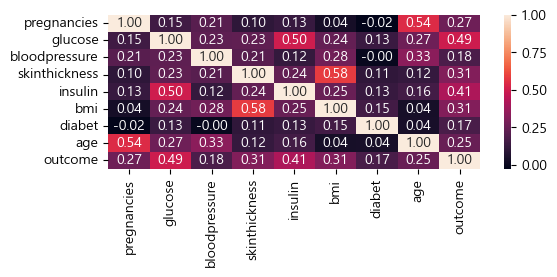

In [80]:
plt.figure(figsize=(6,2))
sns.heatmap(df.corr(), fmt='.2f', annot=True)
plt.show()

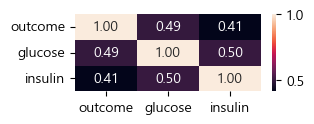

In [81]:
plt.figure(figsize=(3,1))
corr_df = df.corr().nlargest(3, 'outcome')
sns.heatmap(corr_df[corr_df.index], fmt='.2f', annot=True)
plt.show()

In [82]:
df.corr().nlargest(3, 'outcome').index

Index(['outcome', 'glucose', 'insulin'], dtype='object')

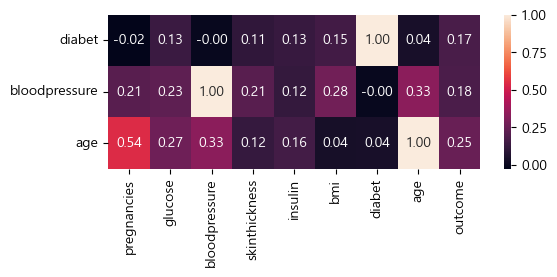

In [83]:
plt.figure(figsize=(6,2))
sns.heatmap(df.corr().nsmallest(3, 'outcome'), fmt='.2f', annot=True)
plt.show()

In [84]:
for col in df.columns:
    print(col, df.corr().nlargest(3, col).index.values[1:])

pregnancies ['age' 'outcome']
glucose ['insulin' 'outcome']
bloodpressure ['age' 'bmi']
skinthickness ['bmi' 'outcome']
insulin ['glucose' 'outcome']
bmi ['skinthickness' 'outcome']
diabet ['outcome' 'bmi']
age ['pregnancies' 'bloodpressure']
outcome ['glucose' 'insulin']


# 교차검증
* 다량 학습
* https://amueller.github.io/aml/04-model-evaluation/1-data-splitting-strategies.html

In [85]:
y = df['outcome']
X = df.drop('outcome', axis=1)
model = DecisionTreeClassifier(random_state=111, min_samples_split=2)

skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1212)  # 분류
score_arr = cross_val_score(model, X, y, scoring="f1_macro", cv=skfold) 
print(f"평균점수 : {score_arr.mean():.4f}")

평균점수 : 0.8379


In [86]:
df.iloc[[13, 28]]

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabet,age,outcome
14,5,166.0,72.0,19.0,175.000000,25.8,0.587,51,1
30,5,109.0,75.0,26.0,130.287879,36.0,0.546,60,0


In [87]:
y = df['outcome']
X = df.drop('outcome', axis=1)

score_list = []
skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1212)  
for i, (train_idx, test_idx) in enumerate(skfold.split(X, y)) :  
    X_train, X_test,  y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
    model = DecisionTreeClassifier(random_state=111, min_samples_split=2)
    model.fit(X_train, y_train)
    pred = model.predict( X_test)  
    f1   = f1_score(y_test, pred, average="macro")
    score_list.append(f1)
print(f"평균점수 : {np.mean(score_list):.4f}")

평균점수 : 0.8379


<pre>원본 : accuracy:0.8052 precision:0.7143  recall:0.7407   f1:0.7273  roc:0.7904
[[84 16]
 [14 40]]

 개별 아웃라이어 삭제 : accuracy:0.8675 precision:0.8103  recall:0.8393   f1:0.8246  roc:0.8617
[[84 11]
 [ 9 47]]

# GridSearchCV
* 파라미터 튜닝

In [88]:
model = DecisionTreeClassifier(random_state=111, min_samples_split=2)
    
y = df['outcome']
X = df.drop('outcome', axis=1)
#max_depth=None, min_samples_split=2, min_samples_leaf=1
myparam = { "max_depth" : [10,20,30] ,
            "min_samples_split" : [1,2,3,4],
            "min_samples_leaf" : [1,2,3]
          }

skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1212)  
gcv_model = GridSearchCV(model, param_grid=myparam, scoring="f1_macro", refit=True, cv=skfold)
gcv_model.fit(X, y)

print( gcv_model.best_estimator_ )
print( gcv_model.best_score_)
print( gcv_model.best_params_)

DecisionTreeClassifier(max_depth=10, random_state=111)
0.8378555422134487
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


```python
class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
```

* 배깅 모델로 교체 (기본 파라미터)

In [89]:
y = df['outcome']
X = df.drop('outcome', axis=1)

model = RandomForestClassifier(random_state=1212)
model.fit(X_train, y_train)
pred = model.predict( X_test)  
f1   = f1_score(y_test, pred, average="macro")
print(f"f1 : {f1:.4f}")


skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1212)  # 분류
score_arr = cross_val_score(model, X, y, scoring="f1_macro", cv=skfold) 
print(f"평균점수 : {score_arr.mean():.4f}")
   


f1 : 0.8200
평균점수 : 0.8670


* 배깅모델로 교체 + 파라미터 튜닝

In [90]:
model = RandomForestClassifier(random_state=1212)
    
y = df['outcome']
X = df.drop('outcome', axis=1)
#n_estimators,   max_depth=None, min_samples_split=2, min_samples_leaf=1
myparam = { "n_estimators": [300, 400, 500], 
            "max_depth" : [10,20,30] ,
            "min_samples_split" : [3,4,5,6],
            "min_samples_leaf" : [1,2,3]
          }

skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1212)  
gcv_model = GridSearchCV(model, param_grid=myparam, scoring="f1_macro", refit=True, cv=skfold)
gcv_model.fit(X, y)

print( gcv_model.best_estimator_ )
print( gcv_model.best_score_)
print( gcv_model.best_params_)

RandomForestClassifier(max_depth=20, min_samples_split=4, n_estimators=300,
                       random_state=1212)
0.8682821569033173
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300}


# AutoML : pycaret
* 모델 변경 ( boosting, bagging, ensemble)
* 하이퍼파라미터 튜닝  

In [91]:
from pycaret.classification import *
s = setup(df, target = 'outcome', train_size=0.8, fold=3, fold_shuffle=True, session_id=1212)  #, silent=True

best_model = compare_models(exclude = ['catboost'] , n_select = 4, sort='F1')
print(best_model)

,Description,Value
0,Session id,1212
1,Target,outcome
2,Target type,Binary
3,Original data shape,"(755, 9)"
4,Transformed data shape,"(755, 9)"
5,Transformed train set shape,"(604, 9)"
6,Transformed test set shape,"(151, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8858,0.9444,0.7975,0.8662,0.8300,0.7443,0.7461,0.3133
lightgbm,Light Gradient Boosting Machine,0.8775,0.9471,0.8117,0.8367,0.8221,0.7289,0.7311,0.2500
rf,Random Forest Classifier,0.8758,0.9283,0.8020,0.8378,0.8195,0.7249,0.7253,0.3233
xgboost,Extreme Gradient Boosting,0.8725,0.9428,0.8067,0.8260,0.8158,0.7184,0.7189,0.2433
ada,Ada Boost Classifier,0.8610,0.9041,0.7551,0.8325,0.7917,0.6878,0.6898,0.2767
et,Extra Trees Classifier,0.8543,0.9242,0.7879,0.7954,0.7916,0.6796,0.6796,0.3567
knn,K Neighbors Classifier,0.8477,0.8844,0.7547,0.8051,0.7776,0.6620,0.6642,1.2533
dt,Decision Tree Classifier,0.8245,0.8139,0.7784,0.7366,0.7569,0.6198,0.6204,0.2333
nb,Naive Bayes,0.7865,0.8682,0.6982,0.6975,0.6971,0.5323,0.5330,0.2233
lr,Logistic Regression,0.8013,0.8777,0.6415,0.7565,0.6941,0.5484,0.5526,2.2033


[GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=1212, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False), LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1212, reg_alpha=0.0, reg_lambda=0.0, sub

# Optuna
* https://optuna.org/
* 하이퍼파라미터 튜닝

<ol>
<li>Wrap model training with an<code>objective</code> function and return accuracy</li>
<li><code>Suggest hyperparameters</code> using a <code>trial</code> object</li>
<li>Create a <code>study</code> object and execute the optimization</li>
</ol>

In [92]:
import optuna
import logging 

optuna.logging.set_verbosity(logging.CRITICAL)

y = df['outcome']
X = df.drop('outcome', axis=1)

def rf_objective(trial) : 
    v_n_estimators      = trial.suggest_int("n_estimators", 300, 500, 100)
    v_max_depth         = trial.suggest_int("max_depth", 10,30, 10 )
    v_min_samples_split = trial.suggest_int("min_samples_split", 3,6, 1)
    v_min_samples_leaf  = trial.suggest_int("min_samples_leaf",1,3, 1)

    model = RandomForestClassifier(random_state=1212,
                                   n_estimators = v_n_estimators,
                                   max_depth = v_max_depth,
                                   min_samples_split= v_min_samples_split,
                                   min_samples_leaf = v_min_samples_leaf          
                                  )
    #n_estimators=,   max_depth=None, min_samples_split=2, min_samples_leaf=1

    skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1212)  
    score = cross_val_score(model, X, y, cv=skfold, scoring="f1").mean()
    return score

In [93]:
study = optuna.create_study(direction="maximize")
study.optimize(rf_objective, n_trials=10)
print(study.best_trial.value)
print(study.best_trial.params)
# {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300}
# 0.8682821569033173

0.8253639145194813
{'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1}


# 임계치 조정

In [94]:
from sklearn.preprocessing import Binarizer

* 연습용

In [95]:
from sklearn.preprocessing import Binarizer
X = [[ 1., -1.,  2.],
      [ 2.,  0.,  0.],
      [ 0.,  1., -1.]]
bz = Binarizer(threshold=0.0)
bz.fit(X)
res = bz.transform(X)
print( res )
# ------------------ 임계치를 최대로 올리면 모든 데이터가 음성
bz = Binarizer(threshold=2)
bz.fit(X)
res = bz.transform(X)
print( res )
# ------------------ 임계치를 최저로 내리면 모든 데이터가 양성
bz = Binarizer(threshold=-2)
bz.fit(X)
res = bz.transform(X)
print( res )

[[1. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


## precision_recall_curve
* 학습데이터의 임계치 확인용

In [107]:
y = df['outcome']
X = df.drop('outcome', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

model = RandomForestClassifier(random_state=1212,
                                max_depth=20, 
                                min_samples_leaf=1, 
                                min_samples_split=4, 
                                n_estimators=300
                                )
model.fit(X_train, y_train)
pred = model.predict(X_test)  
proba = model.predict_proba(X_test) 

accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall    = recall_score(y_test, pred)
f1        = f1_score(y_test, pred)
roc = roc_auc_score(y_test, proba[:, 1])

print(f"accuracy:{accuracy:.4f} precision:{precision:.4f}  recall:{recall:.4f}   f1:{f1:.4f}  roc:{roc:.4f}")
print( confusion_matrix(y_test, pred) )

accuracy:0.8742 precision:0.8776  recall:0.7679   f1:0.8190  roc:0.9391
[[89  6]
 [13 43]]


146 146 145


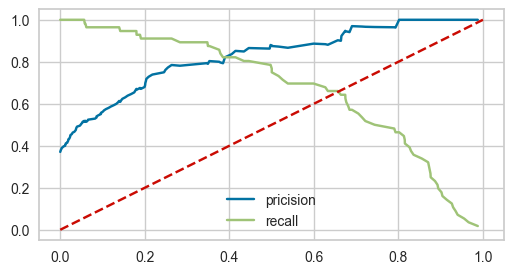

In [108]:
# precision, recall, th = precision_recall_curve(y_true, y_scores)
plt.figure(figsize=(6,3))
precision, recall, th = precision_recall_curve(y_test, proba[:, 1])
print(len(precision), len(recall),  len(th))
plt.plot(th, precision[ : len(th)] , label="pricision")
plt.plot(th, recall[ : len(th)]    , label="recall")
plt.plot([0,1], [0,1], linestyle = '--')
plt.legend()
plt.show()

In [98]:
# print(precision)
# print(recall)
# print(th)

In [121]:
temp = pd.DataFrame()
temp['precision'] = precision[:len(th)]
temp['recall']    = recall[:len(th)]
temp['th']        = th
temp['f1']        =  2* (temp['precision'] *temp['recall']) / (temp['precision'] +temp['recall'] )
temp['roc']       = roc

In [122]:
idx = range(0, len(temp), 10)
temp.iloc[idx]

,precision,recall,th,f1,roc
0,0.370861,1.000000,0.000000,0.541063,0.939098
10,0.411765,1.000000,0.013333,0.583333,0.939098
20,0.444444,1.000000,0.023667,0.615385,0.939098
30,0.482759,1.000000,0.037611,0.651163,0.939098
40,0.514286,0.964286,0.061833,0.670807,0.939098
50,0.568421,0.964286,0.103444,0.715232,0.939098
60,0.623529,0.946429,0.146944,0.751773,0.939098
70,0.680000,0.910714,0.199611,0.778626,0.939098
80,0.784615,0.910714,0.263452,0.842975,0.939098
90,0.836364,0.821429,0.405611,0.828829,0.939098


* 적정 임계치

In [118]:
temp[temp['precision'] == temp['recall']]

,precision,recall,th,f1,roc
89,0.821429,0.821429,0.389802,0.821429,0.939098


* 최대 f1

In [119]:
temp[temp['f1'] == np.max(temp['f1'])]

,precision,recall,th,f1,roc
80,0.784615,0.910714,0.263452,0.842975,0.939098


## 임계치 조정
* 현재: 0.389802

In [130]:
# print( len(proba[:, -1]),  proba[:5] )
bz = Binarizer(threshold=0.389802)
data = proba[:, -1]
res = bz.fit_transform(data.reshape(-1,1))
temp2 = pd.DataFrame()
temp2['y_test'] = y_test
temp2['pred0.5'] = pred
temp2[['proba0','proba1']] = proba
temp2['bin0.38'] = res
temp2['bin0.38'] = temp2['bin0.38'].astype(int)
temp2 [temp2['y_test'] == temp2['pred0.5']].head()

,y_test,pred0.5,proba0,proba1,bin0.38
669,0,0,0.594389,0.405611,1
75,0,0,0.998333,0.001667,0
276,1,1,0.499643,0.500357,1
464,0,0,0.917611,0.082389,0
529,0,0,0.962722,0.037278,0


In [133]:
for th in [0.34, 0.36, 0.389802, 0.40, 0.42] : 
    bz = Binarizer(threshold=th)
    data = proba[:, -1]
    biz_res   = bz.fit_transform(data.reshape(-1,1))
    print(biz_res.reshape(-1))
    
    f1_orig   = f1_score(y_test, pred)
    
    biz_precision = precision_score(y_test, biz_res)
    biz_recall    = recall_score(y_test, biz_res)
    biz_f1        = f1_score(y_test, biz_res)  #0 --> 1
    biz_roc       = roc_auc_score(y_test, biz_res)
    
    print(f"biz_precision:{biz_precision:.4f} biz_recall:{biz_recall:.4f} f1_orig: {f1_orig:.4f}  biz_f1:{biz_f1:.4f} biz_roc:{biz_roc:.4f} th:{th}")
    print(confusion_matrix(y_test, biz_res))
    print("---"*20)

[1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.
 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1.
 0. 1. 0. 0. 0. 1. 0.]
biz_precision:0.7937 biz_recall:0.8929 f1_orig: 0.8190  biz_f1:0.8403 biz_roc:0.8780 th:0.34
[[82 13]
 [ 6 50]]
------------------------------------------------------------
[1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.
 

* 검증용

In [134]:
# -------------------------------------------------
#0.8190933333333333  vs. 0.840382698920906
# -------------------------------------------------
# pre=0.8364 
# recall=0.8214

pre=0.7937
recall=0.8929 

f1 =   2*(pre*recall)/(pre+recall)
f1  

0.840382698920906